In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and clean data
dataset_dir = r"C:\Users\chenn\OneDrive\Desktop\btp\dataset_btp"
csv_path = os.path.join(dataset_dir, "BTP_1_Dataset.csv")
df = pd.read_csv(csv_path)

df["Power_to_Speed"] = df["Laser_Power"] / df["Scan_Speed"]
df["Energy_Density"] = df["Laser_Power"] / (df["Spot_Diameter"] * df["Scan_Speed"])
df["Flow_to_Cooling"] = df["Material_FlowRate"] / (df["Cooling_Rate"] + 1e-6)
df = df.drop(columns=['Stand_Off', 'Spot_Diameter', 'Material_FlowRate'])
df = pd.get_dummies(df, columns=['Material_Type'], prefix='Material')

numerical_features = ['Laser_Power', 'Scan_Speed', 'Cooling_Rate',
                      'Power_to_Speed', 'Energy_Density', 'Flow_to_Cooling']
categorical_features = [col for col in df.columns if col.startswith('Material_')]
features = numerical_features + categorical_features
targets = ['Aspect_Ratio', 'Dilution_Percent', 'PCE_Percent']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

def preprocess_image_densenet(path):
    full_path = os.path.join(dataset_dir, path) if not os.path.isabs(path) else path
    img = load_img(full_path, target_size=(224,224), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = densenet_preprocess(img_array)
    return img_array

image_arrays = np.array([preprocess_image_densenet(img_path) for img_path in df['Images']], dtype=np.float32)
X_num = df[features].values.astype(np.float32)
Y = df[targets].values.astype(np.float32)

X_num_train, X_num_test, X_img_train, X_img_test, Y_train, Y_test = train_test_split(
    X_num, image_arrays, Y, test_size=0.2, random_state=42
)

# Define model inputs
img_input = Input(shape=(224,224,3), name='image_input')
num_input = Input(shape=(X_num_train.shape[1],), name='numerical_input')

# Image augmentation
augmented = RandomFlip("horizontal_and_vertical")(img_input)
augmented = RandomRotation(0.2)(augmented)
augmented = RandomZoom(0.2)(augmented)
augmented = RandomBrightness(0.2)(augmented)

# DenseNet121 backbone
base_cnn = DenseNet121(include_top=False, weights='imagenet', pooling='avg')
base_cnn.trainable = False

img_features = base_cnn(augmented)
img_features = BatchNormalization()(img_features)
img_features = Dropout(0.3)(img_features)

# Numerical branch
x_num = Dense(64, activation='relu')(num_input)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.3)(x_num)
x_num = Dense(32, activation='relu')(x_num)

# Early fusion by concatenation
combined = Concatenate()([x_num, img_features])
x = Dense(64, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(len(targets), activation='linear')(x)

model = Model([num_input, img_input], output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model.fit([X_num_train, X_img_train], Y_train, validation_split=0.2,
                    epochs=500, batch_size=8, callbacks=[early_stop], verbose=1)

# Evaluate
loss, mae = model.evaluate([X_num_test, X_img_test], Y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Y_pred = model.predict([X_num_test, X_img_test])
for i, target in enumerate(targets):
    mae_val = mean_absolute_error(Y_test[:, i], Y_pred[:, i])
    mse_val = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(Y_test[:, i], Y_pred[:, i])
    print(f"\n{target} Metrics:")
    print(f"MAE: {mae_val:.3f}, MSE: {mse_val:.3f}, RMSE: {rmse_val:.3f}, R2: {r2_val:.3f}")

# Save model
#model.save("early_fusion_densenet121.keras")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_flip (RandomFlip)      │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_rotation               │ (None, 224, 224, 3)       │               0 │ random_flip[0][0]          │
│ (RandomRotation)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numerical_input (InputLayer)  │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_zoom (RandomZoom)      │ (None, 224, 224, 3)       │               0 │ random_rotation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │             640 │ numerical_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ random_brightness             │ (None, 224, 224, 3)       │               0 │ random_zoom[0][0]          │
│ (RandomBrightness)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64)                │             256 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ densenet121 (Functional)      │ (None, 1024)              │       7,037,504 │ random_brightness[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024)              │           4,096 │ densenet121[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           2,080 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1024)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1056)              │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │          67,64

 Total params: 7,112,675 (27.13 MB)

 Trainable params: 72,867 (284.64 KB)

 Non-trainable params: 7,039,808 (26.85 MB)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 93s 24s/step - loss: 947.4662 - mae: 25.3335 - val_loss: 891.3773 - val_mae: 24.5551
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 947.6293 - mae: 25.4187 - val_loss: 883.5746 - val_mae: 24.4395
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 952.8176 - mae: 25.4532 - val_loss: 875.8674 - val_mae: 24.3305
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 965.1473 - mae: 25.6530 - val_loss: 871.4928 - val_mae: 24.2707
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 957.0612 - mae: 25.3680 - val_loss: 873.4149 - val_mae: 24.3185
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 967.4803 - mae: 25.7629 - val_loss: 875.6306 - val_mae: 24.3675
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 947.6477 - mae: 25.4081 - val_loss: 878.4893 - val_mae: 24.4278
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - loss: 939.8820 - mae: 25.2812 - val_loss: 879.1256 - val_mae: 24.4590
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Aspect_Ratio Metrics:
  MAE: 0.834
  MSE: 0.824
  RMSE: 0.908
  R²: -4.686


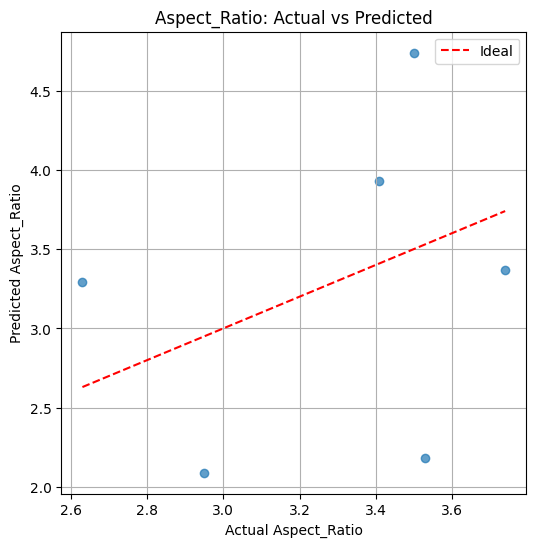

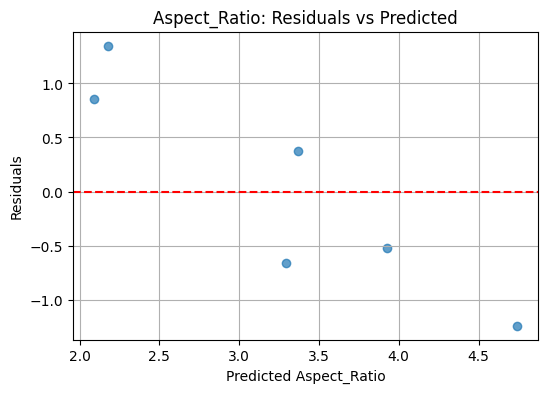


Dilution_Percent Metrics:
  MAE: 3.377
  MSE: 16.193
  RMSE: 4.024
  R²: 0.565


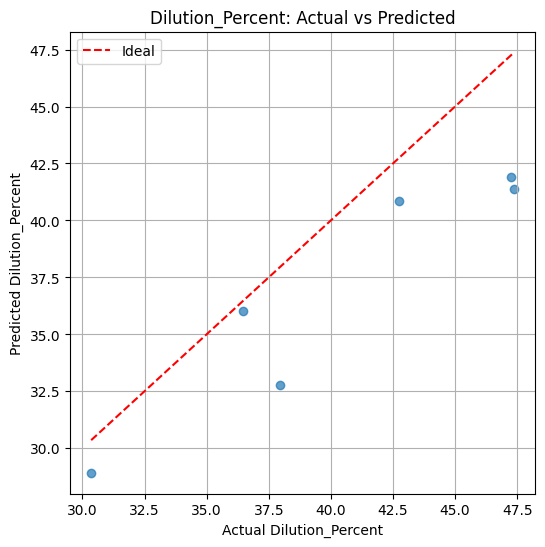

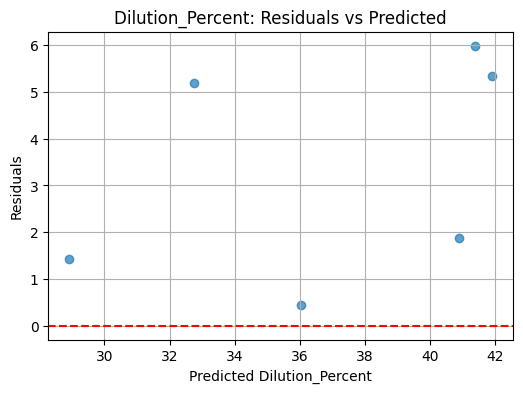


PCE_Percent Metrics:
  MAE: 3.922
  MSE: 22.747
  RMSE: 4.769
  R²: 0.744


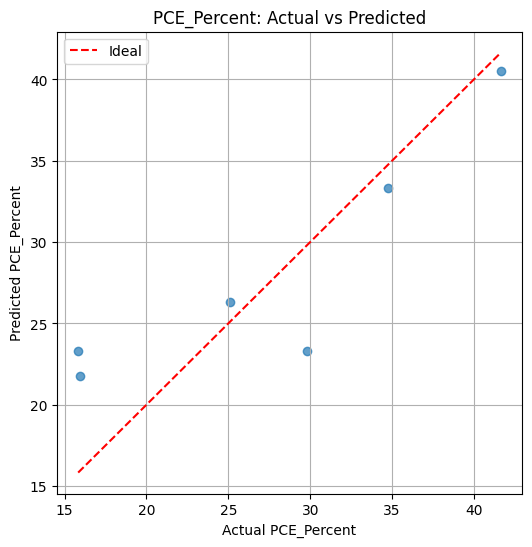

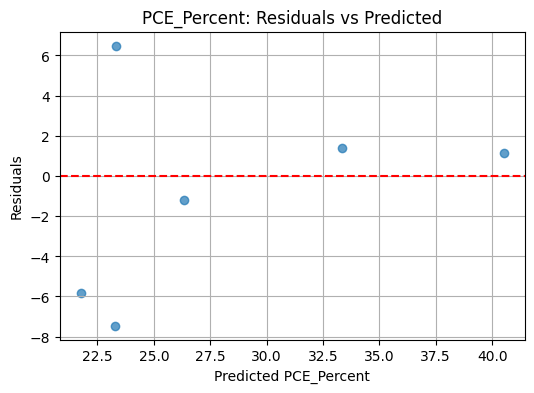

In [2]:
# Predict on test set
Y_pred = model.predict([X_num_test, X_img_test])

for i, target in enumerate(targets):
    mae = mean_absolute_error(Y_test[:, i], Y_pred[:, i])
    mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    print(f"\n{target} Metrics:")
    print(f"  MAE: {mae:.3f}")
    print(f"  MSE: {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²: {r2:.3f}")

    # Actual vs Predicted plot
    plt.figure(figsize=(6,6))
    plt.scatter(Y_test[:, i], Y_pred[:, i], alpha=0.7)
    plt.plot([Y_test[:, i].min(), Y_test[:, i].max()],
             [Y_test[:, i].min(), Y_test[:, i].max()],
             'r--', label='Ideal')
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = Y_test[:, i] - Y_pred[:, i]
    plt.figure(figsize=(6,4))
    plt.scatter(Y_pred[:, i], residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel(f"Predicted {target}")
    plt.ylabel("Residuals")
    plt.title(f"{target}: Residuals vs Predicted")
    plt.grid(True)
    plt.show()

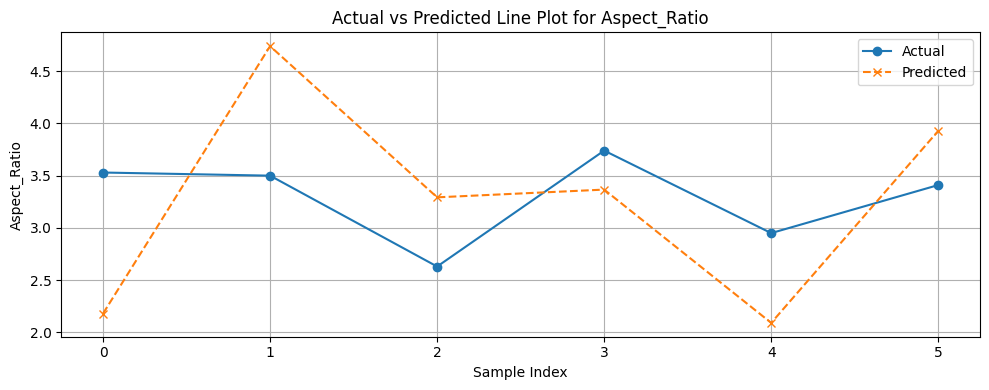

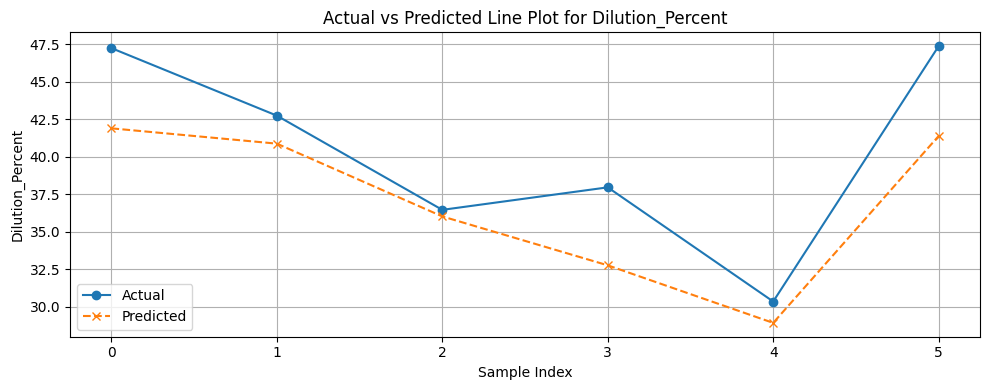

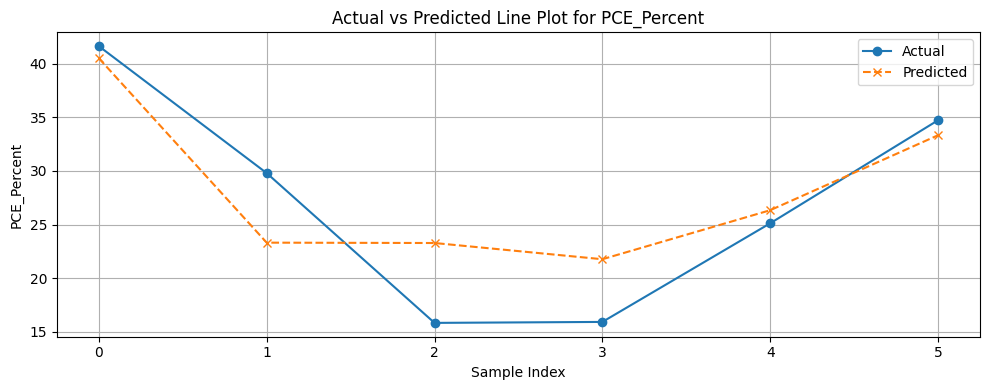

In [3]:
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[:, i], label='Actual', linestyle='-', marker='o')
    plt.plot(Y_pred[:, i], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Line Plot for {target}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

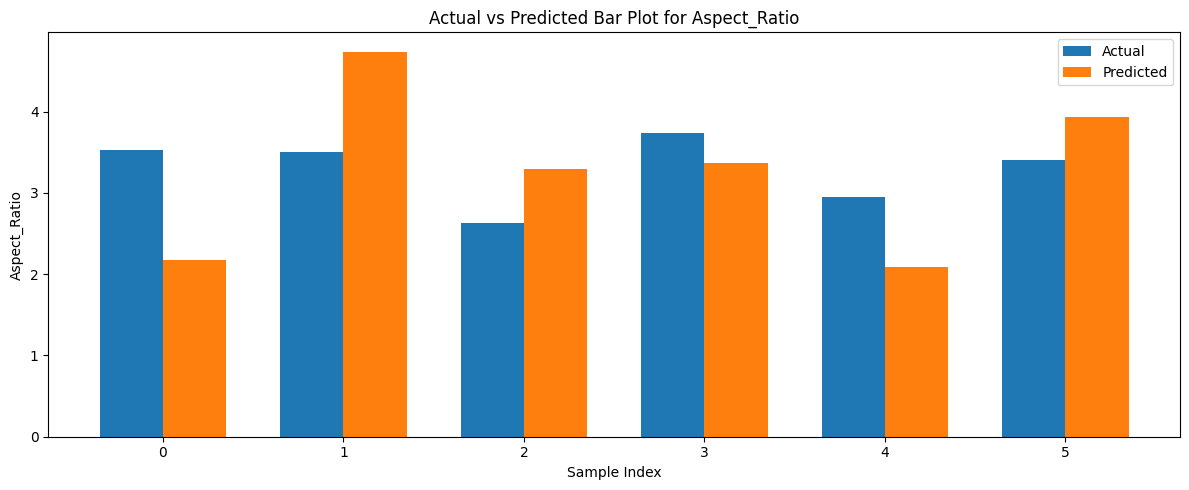

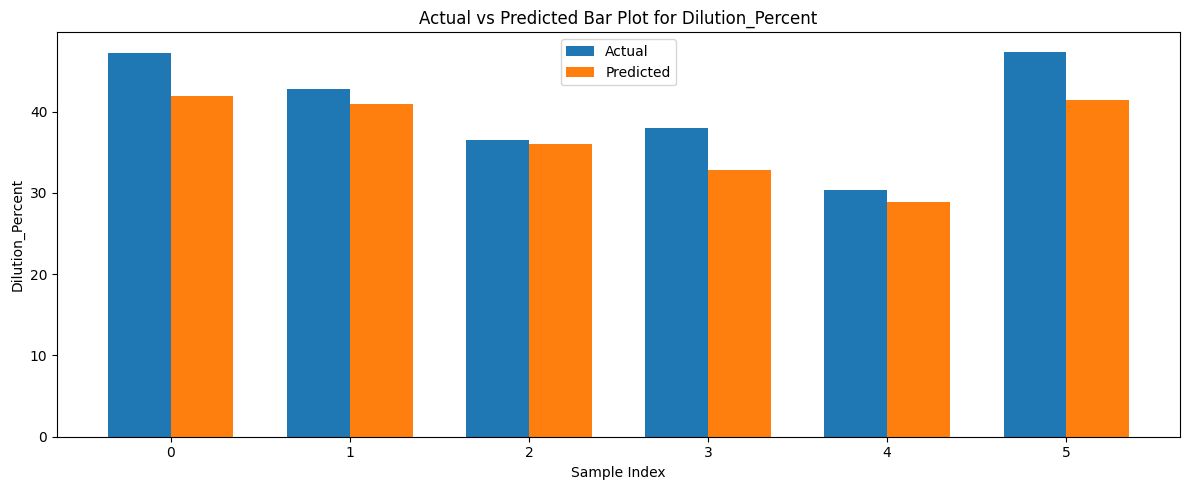

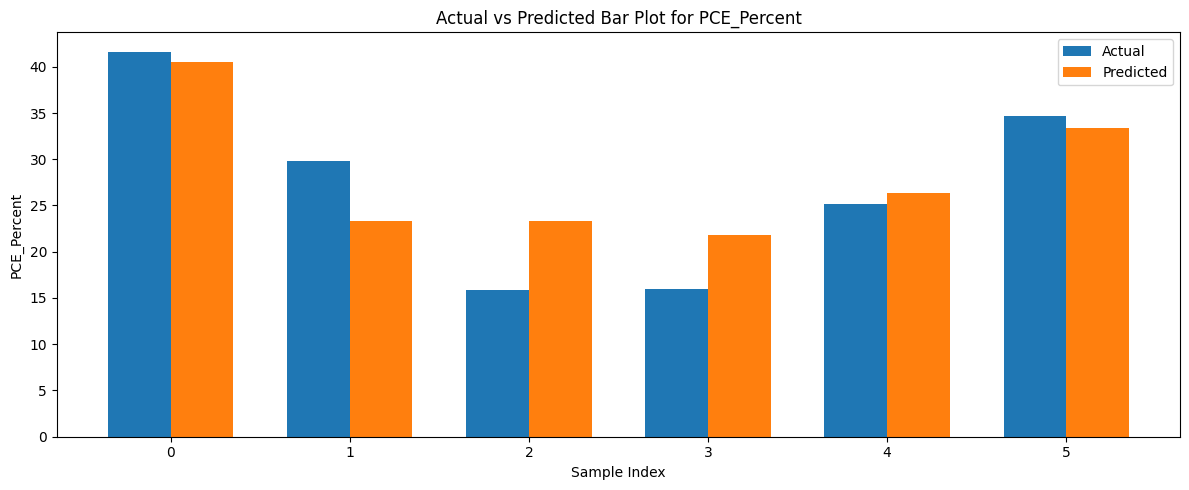

In [4]:
for i, target in enumerate(targets):
    x = np.arange(len(Y_test[:, i]))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, Y_test[:, i], width, label='Actual')
    plt.bar(x + width/2, Y_pred[:, i], width, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Bar Plot for {target}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
mse_total = np.mean((Y_test - Y_pred)**2)
print(f"Overall MSE (orig units): {mse_total:.4f}")

Overall MSE (orig units): 13.2549


In [7]:
# Save model
model.save("early_fusion_densenet121.keras")